_Version Log: Changing from angles $\alpha$ and $\beta$ to $k$ and $\phi$ ._

In [242]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches

source= "FBH800"  # "blue" "green" "red" "FBH800" "ir" "FBH1600" 
grating= 300 #mm^-1
order = 1
run= 7
file_type= ".csv"
distance_to_screen = 577 #mm
blaze_angle = 4 + 18/60 #degrees
camera = "pyro" #"manta" "xeva" "purple" "pyro"
ROI = np.array([[0,320],[0,320]]) #region of interest in pixels. rows, columns. [[0,240],[0,320]] [[0,512],[0,640]] [[0,492],[0,656]], [[0,320],[0,320]]

if camera == "manta":
    pixel_pitch = 9.9 #um
elif camera == "xeva":
    pixel_pitch = 20 #um
elif camera == "purple":
    pixel_pitch = 48.5 #um
elif camera == "pyro":
    pixel_pitch = 80 #um
else:
    raise ValueError(camera + " is not a valid camera.")

In [243]:
def find_files(source, grating, order, number, file_type):
    file_names = os.listdir("data\\")
    new_file_names=[]
    for file_name in file_names:
        check = re.findall('^'+source+'_'+str(grating)+"_n"+str(order)+"_"+str(number)+'_*.*'+file_type , file_name)
        if len(check) != 0:
            new_file_names = new_file_names + [file_name]
    return new_file_names

def find_delimiter(csv_file_name):
    with open('data\\'+csv_file_name, 'r') as file: #openai did this bit for me. It automatically detects which delimiter to use (pyro uses , xeva uses ;)
            first_line = file.readline()
            if ';' in first_line:
                delimiter = ';'
            else:
                delimiter = ','
    return delimiter

def import_data(source, grating, order, number, file_type):
    file_names = find_files(source= source, grating= grating, order= order, number= number, file_type= file_type)
    if file_type == ".csv":
        delimiter = find_delimiter(file_names[0])
        if len(file_names) == 1: # no background image
            data = np.genfromtxt("data\\"+file_names[0], delimiter= delimiter, dtype= np.float32, filling_values= np.nan)
        elif len(file_names) == 2:
            data = np.genfromtxt("data\\"+file_names[0], delimiter= delimiter, dtype= np.float32, filling_values= np.nan)
            bg = np.genfromtxt("data\\"+file_names[1], delimiter= delimiter, dtype= np.float32, filling_values= np.nan)
            data -= bg #backgound subtract
    return data

def diffaction(k, phi, n, g): #half deviation angle, scan angle, order, grove density
    k = np.deg2rad(np.array(k)) #convert to a np.array in radians
    phi = np.deg2rad(np.array(phi))
    n = np.array(n)
    g *= 1e3 #convert from mm^-1 to m^-1
    sinusoid = np.cos(k) *np.sin(phi).T #sinusoid doesn't hold much physical significance but it is a good intermediary.
    wavelength = 2 *sinusoid.T /n /g
    return wavelength

def import_normalised_csv(file_name, start_row):
    File = open('data\\'+file_name, 'rt')
    array = np.loadtxt(File, skiprows=start_row, delimiter = ",")
    File.close()
    array[:,1] = array[:,1] / np.max(array[:,1]) #normalise
    return array

def read_metadata(): #would be nice to filter by relivent data files.
    df = pd.read_excel("data\\metadata.xlsx")
    return df

def arc2deg(arcs):
    arcs = np.array(arcs)
    arcs_shape = arcs.shape
    arcs = arcs.flatten()
    arcs = pd.Series(arcs) # Allows for compatibilty with both 0d and 1d data. np.array cannot iterate over 0d. lists will turn 1d arrays into 2d.

    degrees=[]
    for arc in arcs:

        deg = re.findall("[0-9]+°" , arc)
        min = re.findall("[0-9]+\'" , arc)
        sec = re.findall("[0-9]+\"" , arc)

        deg, min, sec = [0 if len(angle_segment) == 0 else float(angle_segment[0][:-1]) for angle_segment in [deg, min, sec]]

        degrees = degrees + [deg + min/60 + sec/3600]

    degrees = np.array(degrees)
    degrees = degrees.reshape(arcs_shape)

    return degrees

In [244]:
df = read_metadata()
df = df.loc[df["run number"] == run] #filter by run
#df = df.loc[df["run number"] != 1] #filter by run
df[["blaze angle (degrees)","absolute measured angle (degrees)","absolute normal"]] = arc2deg(df[["blaze angle (degrees)","absolute measured angle (degrees)","absolute normal"]]) #convert angles from degress of an arc to decimal degrees
df

,light source,light source nickname,run number,date taken,grating density (mm^-1),blaze angle (degrees),camera,distance to camera (mm),order,absolute measured angle (degrees),absolute normal,other comments
20,white source SLS201L,ir,7,2023-11-06,300,4.3,Pyrocam IV,577,0,162.25,196.166667,used Czerny-Turner configeration. (IMAGES ARE ...
21,white source SLS201L,ir,7,2023-11-06,300,4.3,Pyrocam IV,577,1,170.00,196.166667,NaN
22,FBH800 filter,FBH800,7,2023-11-06,300,4.3,Pyrocam IV,577,1,170.00,196.166667,NaN


In [245]:
df["relative angle"] = df["absolute measured angle (degrees)"] - df["absolute normal"]
df["angle_k"] = float(df.where(df["order"] == 0).dropna()["relative angle"].iloc[0]) #find the relative angle for order = 0. This is pretty ugly. Find a cleaner solution if you can.
df["angle_phi"] = df["relative angle"] - df["angle_k"]
df["angle_k"] = np.abs(df["angle_k"])
df

,light source,light source nickname,run number,date taken,grating density (mm^-1),blaze angle (degrees),camera,distance to camera (mm),order,absolute measured angle (degrees),absolute normal,other comments,relative angle,angle_k,angle_phi
20,white source SLS201L,ir,7,2023-11-06,300,4.3,Pyrocam IV,577,0,162.25,196.166667,used Czerny-Turner configeration. (IMAGES ARE ...,-33.916667,33.916667,0.00
21,white source SLS201L,ir,7,2023-11-06,300,4.3,Pyrocam IV,577,1,170.00,196.166667,NaN,-26.166667,33.916667,7.75
22,FBH800 filter,FBH800,7,2023-11-06,300,4.3,Pyrocam IV,577,1,170.00,196.166667,NaN,-26.166667,33.916667,7.75


In [246]:
########IT WOULD BE NICE TO GET THIS INFO FROM THE METADATA SHEET AND REDUCE THE NUMBER OF FILTERS

#but then hefest got...
this_run = df.loc[(df["light source nickname"] == source) & 
                     (df["run number"] == run) & 
                     (df["grating density (mm^-1)"] == grating) & 
                     (df["blaze angle (degrees)"] == blaze_angle) &
                     #(df["camera"] == camera) & #the cameras have nicknames so this doesn't work
                     (df["distance to camera (mm)"] == distance_to_screen) &
                     (df["order"] == order)]

k = float(this_run["angle_k"].iloc[0])
phi = float(this_run["angle_phi"].iloc[0])

print("k = {0:1f} and φ = {1:1f}".format(k, phi))

k = 33.916667 and φ = 7.750000


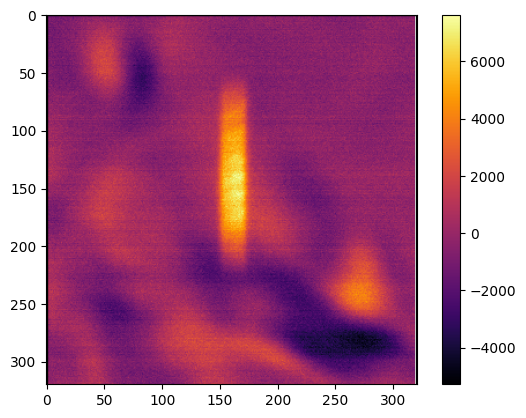

In [247]:
array = import_data(source= source, grating= grating, order= order, number= run, file_type= file_type)

ax = plt.subplot(1,1,1)

im = plt.imshow(array, cmap= "inferno")
rect = patches.Rectangle((ROI[1][0], ROI[0][0]), ROI[1][1]-ROI[1][0], ROI[0][1]-ROI[0][0], linewidth=1, edgecolor='k', facecolor='none')
ax.add_patch(rect)
plt.colorbar(im)
plt.show()

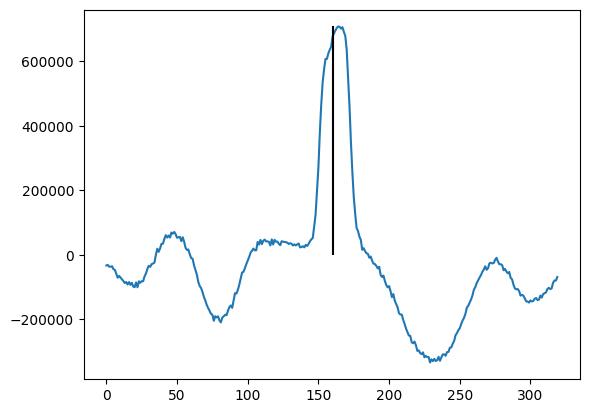

In [248]:
array_cropped = array[ROI[0][0]:ROI[0][1], ROI[1][0]:ROI[1][1]]

spectrum = np.sum(array_cropped, axis= 0)

plt.plot(spectrum)
plt.vlines((ROI[1][1] -ROI[1][0]) /2, 0, np.max(spectrum), color= "k")
plt.show()

In [249]:
central_wavelength = diffaction(k, phi, order, grating)

array_size = pixel_pitch*1e-3*len(spectrum)
max_angular_deviation = np.arctan(array_size /2 /distance_to_screen)
max_angular_deviation = np.rad2deg(max_angular_deviation)

ks = np.linspace(k -max_angular_deviation, k +max_angular_deviation, len(spectrum))
phis = np.linspace(phi -max_angular_deviation/2, phi +max_angular_deviation/2, len(spectrum))

wavelengths = diffaction(ks, phis, order, grating)

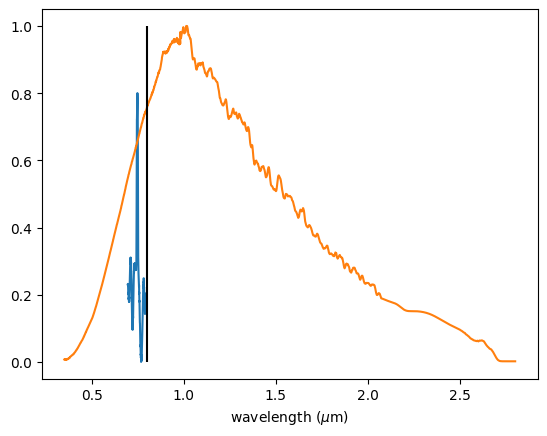

In [250]:
ir_data = import_normalised_csv("SLS201L_spectrum.csv", 1)

spectrum -= np.nanmin(spectrum)
spectrum /= np.nanmax(spectrum)

plt.plot(wavelengths*1e6, spectrum*0.8)
plt.plot(ir_data[:,0]*1e-3, ir_data[:,1])

plt.xlabel("wavelength ($\mu$m)")
plt.vlines(0.8, 0, 1, color= "k")

plt.show()

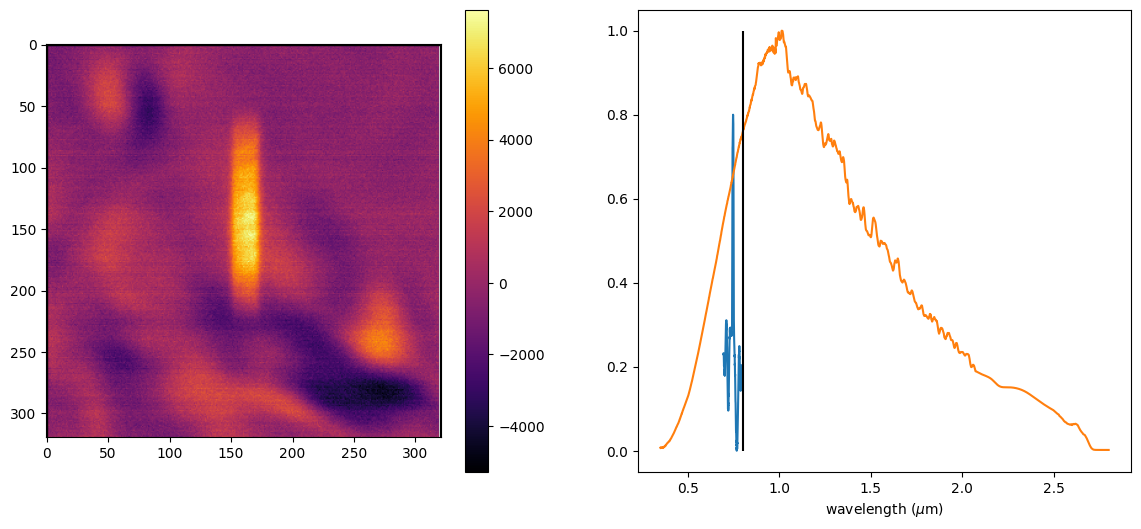

In [251]:
plt.figure(figsize = (14,6))

ax = plt.subplot(1,2,1)

im = plt.imshow(array, cmap= "inferno")
rect = patches.Rectangle((ROI[1][0], ROI[0][0]), ROI[1][1]-ROI[1][0], ROI[0][1]-ROI[0][0], linewidth=1, edgecolor='k', facecolor='none')
ax.add_patch(rect)
plt.colorbar(im)


ax2 = plt.subplot(1,2,2)
plt.plot(wavelengths*1e6, spectrum*0.8, label= "spectrometer data")
plt.plot(ir_data[:,0]*1e-3, ir_data[:,1], label= "SLS201L source spectrum")

plt.xlabel("wavelength ($\mu$m)")
plt.vlines(0.8, 0, 1, color= "k", label= "800nm")

plt.show()